# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function
from jupyterthemes import jtplot
jtplot.style(theme='onedork')
# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

ModuleNotFoundError: No module named 'jupyterthemes'

## CIFAR-10 Data Loading and Preprocessing

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


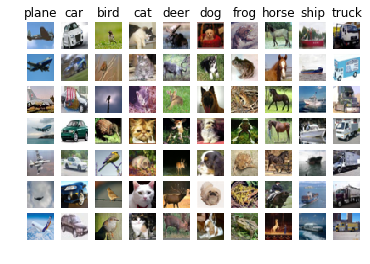

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)#非零元素的位置
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [5]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


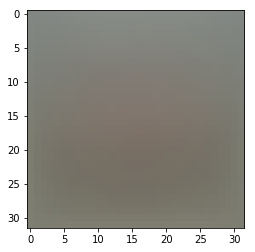

In [6]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [7]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [8]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])#水平连接个长度为图片数的全为1数组
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [9]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 9.249276


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [41]:
A=np.array([[1,2,2],[2,3,4],[1,2,3]])
B=np.sum(A,axis=1)
C=np.sum(A,axis=0)
print(np.argmax(A,axis=1))
print(A[:-1,:])
print(B)
print(C)
print(D)

[1 2 2]
[[1 2 2]
 [2 3 4]]
[5 9 6]
[4 7 9]


NameError: name 'D' is not defined

In [10]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 10.900200 analytic: 10.900200, relative error: 1.332944e-11
numerical: 13.262220 analytic: 13.262220, relative error: 1.216869e-11
numerical: -1.221316 analytic: -1.221316, relative error: 3.001311e-10
numerical: 20.499045 analytic: 20.499045, relative error: 9.948062e-14
numerical: 0.212921 analytic: 0.212921, relative error: 1.192847e-09
numerical: 5.027251 analytic: 5.027251, relative error: 7.057283e-11
numerical: 9.692119 analytic: 9.692119, relative error: 1.147653e-11
numerical: 12.756143 analytic: 12.756143, relative error: 4.328742e-13
numerical: 7.229481 analytic: 7.229481, relative error: 1.333592e-13
numerical: -14.662694 analytic: -14.662694, relative error: 1.734840e-11
numerical: -2.225780 analytic: -2.225780, relative error: 8.061645e-11
numerical: 0.065742 analytic: 0.065742, relative error: 3.763592e-09
numerical: -3.631468 analytic: -3.631468, relative error: 2.348716e-11
numerical: 21.668778 analytic: 21.668778, relative error: 9.189865e-12
numerical: -47

### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? How would change the margin affect of the frequency of this happening? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** *fill this in.*

In [11]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 9.249276e+00 computed in 0.519868s
Vectorized loss: 9.249276e+00 computed in 0.143970s
difference: -0.000000


In [12]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.471878s
Vectorized loss and gradient: computed in 0.012000s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [16]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 790.171403
iteration 100 / 1500: loss 289.356251
iteration 200 / 1500: loss 108.415531
iteration 300 / 1500: loss 42.472225
iteration 400 / 1500: loss 18.844338
iteration 500 / 1500: loss 10.257121
iteration 600 / 1500: loss 7.605035
iteration 700 / 1500: loss 5.955225
iteration 800 / 1500: loss 5.645213
iteration 900 / 1500: loss 5.355503
iteration 1000 / 1500: loss 5.259877
iteration 1100 / 1500: loss 5.422102
iteration 1200 / 1500: loss 5.856080
iteration 1300 / 1500: loss 5.399020
iteration 1400 / 1500: loss 5.030447
That took 268.587743s


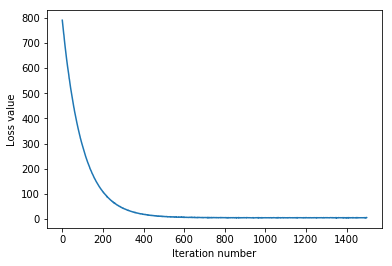

In [17]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [20]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.366633
validation accuracy: 0.372000


In [38]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [1e-7, 2e-7, 3e-7, 5e-5, 8e-7]
regularization_strengths = [1e4, 2e4, 3e4, 4e4, 5e4, 6e4, 7e4, 8e4, 1e5]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

for i in range(0,5):
    for j in range(0,9):
        svm = LinearSVM()
        loss_hist = svm.train(X_train, y_train, learning_rate=learning_rates[i],\
                              reg=regularization_strengths[j],num_iters=1500, verbose=True)
        y_train_pred = svm.predict(X_train)
        y_val_pred = svm.predict(X_val)
        trn_accu=np.mean(y_train == y_train_pred)
        val_accu=np.mean(y_val == y_val_pred)
        results[(learning_rates[i],regularization_strengths[j])]=(trn_accu,val_accu)
        if val_accu > best_val:
            best_val=val_accu
            best_svm=svm
################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
# Your code
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 330.968140
iteration 100 / 1500: loss 216.702395
iteration 200 / 1500: loss 145.330331
iteration 300 / 1500: loss 97.775739
iteration 400 / 1500: loss 67.228205
iteration 500 / 1500: loss 46.133970
iteration 600 / 1500: loss 32.545734
iteration 700 / 1500: loss 23.161584
iteration 800 / 1500: loss 17.056171
iteration 900 / 1500: loss 13.289246
iteration 1000 / 1500: loss 10.120760
iteration 1100 / 1500: loss 8.900590
iteration 1200 / 1500: loss 7.156206
iteration 1300 / 1500: loss 6.893014
iteration 1400 / 1500: loss 5.798356
iteration 0 / 1500: loss 641.692321
iteration 100 / 1500: loss 285.547386
iteration 200 / 1500: loss 129.269791
iteration 300 / 1500: loss 60.123200
iteration 400 / 1500: loss 29.593533
iteration 500 / 1500: loss 16.064020
iteration 600 / 1500: loss 9.325020
iteration 700 / 1500: loss 7.401436
iteration 800 / 1500: loss 6.168286
iteration 900 / 1500: loss 5.604811
iteration 1000 / 1500: loss 5.178010
iteration 1100 / 1500: loss 5.048705
it

iteration 1400 / 1500: loss 5.599720
iteration 0 / 1500: loss 2172.212076
iteration 100 / 1500: loss 13.293145
iteration 200 / 1500: loss 6.129586
iteration 300 / 1500: loss 5.519615
iteration 400 / 1500: loss 5.894222
iteration 500 / 1500: loss 6.348231
iteration 600 / 1500: loss 6.076765
iteration 700 / 1500: loss 5.709966
iteration 800 / 1500: loss 6.007383
iteration 900 / 1500: loss 5.753560
iteration 1000 / 1500: loss 6.127733
iteration 1100 / 1500: loss 5.825902
iteration 1200 / 1500: loss 5.828677
iteration 1300 / 1500: loss 5.947228
iteration 1400 / 1500: loss 6.120626
iteration 0 / 1500: loss 2479.324995
iteration 100 / 1500: loss 9.396836
iteration 200 / 1500: loss 6.015087
iteration 300 / 1500: loss 5.799521
iteration 400 / 1500: loss 5.958074
iteration 500 / 1500: loss 6.383600
iteration 600 / 1500: loss 6.033503
iteration 700 / 1500: loss 6.018719
iteration 800 / 1500: loss 6.151990
iteration 900 / 1500: loss 6.158956
iteration 1000 / 1500: loss 5.912489
iteration 1100 / 1

iteration 400 / 1500: loss 9979939863920033266666123487803854745135347993096110854622402185037603728877880291428425610816773684063602169201879091705844280876083916503423139569136915313945949015049956709206453878699103385020346253909015582948795178777660326728969763160064.000000
iteration 500 / 1500: loss 16037145046749991805200251962386070662000199200662016234104717777017007619028597243193433614487892795287170475819147649830240219292456463595912452673038091510366406782986705282225752360138266507653343100732003575224487731542057103792110667283535067641064211719011111784597744481707235033167048683567448064.000000


D:\file\learn\jupyter notebook\CS231n\spring1718_assignment1\assignment1\cs231n\classifiers\linear_svm.py:79: RuntimeWarning: overflow encountered in double_scalars
  loss+=reg * np.sum(W * W)
D:\Anaconda\Anaconda_install\envs\cs231n\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
D:\file\learn\jupyter notebook\CS231n\spring1718_assignment1\assignment1\cs231n\classifiers\linear_svm.py:79: RuntimeWarning: overflow encountered in multiply
  loss+=reg * np.sum(W * W)


iteration 600 / 1500: loss inf
iteration 700 / 1500: loss inf
iteration 800 / 1500: loss inf
iteration 900 / 1500: loss inf
iteration 1000 / 1500: loss inf


D:\file\learn\jupyter notebook\CS231n\spring1718_assignment1\assignment1\cs231n\classifiers\linear_svm.py:76: RuntimeWarning: overflow encountered in subtract
  judge=score+1-corr_sc
D:\file\learn\jupyter notebook\CS231n\spring1718_assignment1\assignment1\cs231n\classifiers\linear_svm.py:76: RuntimeWarning: invalid value encountered in subtract
  judge=score+1-corr_sc
D:\file\learn\jupyter notebook\CS231n\spring1718_assignment1\assignment1\cs231n\classifiers\linear_svm.py:77: RuntimeWarning: invalid value encountered in less
  judge[judge<0]=0
D:\file\learn\jupyter notebook\CS231n\spring1718_assignment1\assignment1\cs231n\classifiers\linear_svm.py:96: RuntimeWarning: overflow encountered in multiply
  dW=(np.dot(X.T,judge))/X.shape[0]+reg*2*W
D:\file\learn\jupyter notebook\CS231n\spring1718_assignment1\assignment1\cs231n\classifiers\linear_svm.py:94: RuntimeWarning: invalid value encountered in greater
  judge[judge>0]=1


iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
iteration 0 / 1500: loss 1233.246378
iteration 100 / 1500: loss 356149311652708947084156675919161448551817649424803578673517074240733983994283493919316542494867456.000000
iteration 200 / 1500: loss 94598239303474188672631948290253264285378641637874236192469153545859665501806640476150895685574841502463093831610138872790146127389565694333725063777870332926362988862275548032754717487462875136.000000
iteration 300 / 1500: loss 25126615682030628065553427960389800450273903152621835993211214353784444965110372439963957073515996148188528897181394007608498946356790802618080477728821578195594680943020583229708144129933546391037019010972298493617523561100818648247556766299965310764353466815027895908544199169052038397952.000000
iteration 400 / 1500: loss inf
iteration 500 / 1500: loss inf
iteration 600 / 1500: loss inf
iteration 700 / 1500: loss nan
iteration 800 / 1500: l

iteration 0 / 1500: loss 2190.412129
iteration 100 / 1500: loss 6.409523
iteration 200 / 1500: loss 7.157447
iteration 300 / 1500: loss 6.301052
iteration 400 / 1500: loss 8.031138
iteration 500 / 1500: loss 7.834401
iteration 600 / 1500: loss 6.573772
iteration 700 / 1500: loss 6.884709
iteration 800 / 1500: loss 6.719733
iteration 900 / 1500: loss 5.772224
iteration 1000 / 1500: loss 7.025327
iteration 1100 / 1500: loss 7.020022
iteration 1200 / 1500: loss 6.976208
iteration 1300 / 1500: loss 6.583468
iteration 1400 / 1500: loss 6.765278
iteration 0 / 1500: loss 2462.722657
iteration 100 / 1500: loss 7.025019
iteration 200 / 1500: loss 7.174101
iteration 300 / 1500: loss 7.058934
iteration 400 / 1500: loss 7.113029
iteration 500 / 1500: loss 6.381115
iteration 600 / 1500: loss 6.553338
iteration 700 / 1500: loss 6.933283
iteration 800 / 1500: loss 6.438101
iteration 900 / 1500: loss 7.039350
iteration 1000 / 1500: loss 7.425005
iteration 1100 / 1500: loss 6.927557
iteration 1200 / 15

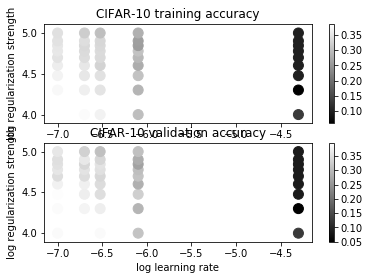

In [39]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [40]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.368000


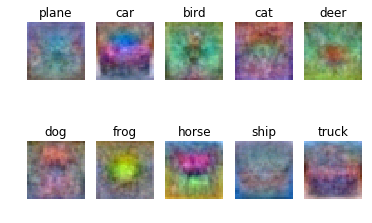

In [42]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    #squeeze 去掉shape为1的维度
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** *fill this in*